Objective: Re-analyze data from March and April 2020 to be compatible with the analysis performed in December 2020.

In [72]:
import os
import sys
sys.path.append('../../../utils/')
from cmptTheoreticalEmitGrowth import *
from bunchLengthConversions import *
from coordinatesConversions import *
from cmpt_TuneSpreads import *

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

### Plotting parameters

In [73]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 10,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Study parameters

In [3]:
n_sets = 20
n_runs = 1
n_turns = int(1e5)            # number of cycles to run the simulation for
decTurns = int(100)           # how often to record data
circumference  = 6911.5623 # [m]
f_rev  = 299792458/circumference  # [Hz] The revolution frequency of the machine 
separationTime = 1 / f_rev * decTurns #There are decTurns revolutions before each recording of data
tspan = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation

In [4]:
my_start = 0  #9.6e3 #400.0
my_stop =  20 #1.6e4 #1.6e4
my_step = 1

my_variables = list(np.arange(my_start, my_stop, my_step))
#my_variables.insert(0,0.0)
print(my_variables)
print(len(my_variables))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
20


In [5]:
path_to_data = '/afs/cern.ch/work/n/natriant/private/pyheadtail_example_crabcavity/old_studies/'
study_name = 'sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_Nowakefields_ayy'
noise_type = 'PN'

### Load the 

- In the current studies (Dec2020) the simulation for each set of noise kicks is repeated 3 times where the initial distribution is re-generated randomly every run. 
- Here only one run was conducted. However, the difference from the initial distribution is negligible.

In [6]:
ex_dict, ey_dict = {}, {} # type: dictionary

for var in my_variables:
    for my_set in range(n_sets):
        temp_name = f'{var}_set{my_set}'
        ex, ey = [], []
        for run in range(n_runs):
            try:
                meanX, meanY, meanXsq, meanYsq, emitX, emitY = np.loadtxt(path_to_data+f'file_run{my_set+1}_ayy{var}.txt', delimiter = ",", unpack = True)
                # B1. Create a different list for each run and save the emittance values
                ex.append(emitX)
                ey.append(emitY)
            except OSError as err:
                print("OS error: {0}".format(err))
                #ex_dict[temp_name] = np.zeros(len(tspan)) 
                #ey_dict[temp_name] = np.zeros(len(tspan))
        ex_dict[temp_name] = np.mean(ex, axis=0)
        ey_dict[temp_name] = np.mean(ey, axis=0)
    
        

Text(0.5, 1.0, 'ayy index 1')

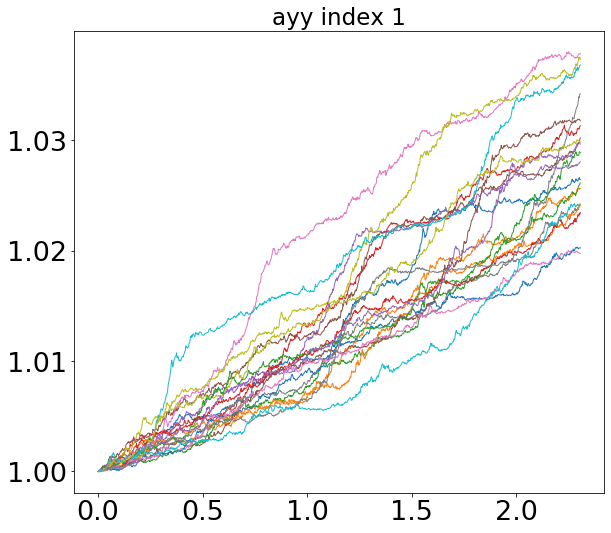

In [81]:
example_index = 1
for my_set in range(n_sets):
    temp_name = f'{my_variables[example_index]}_set{my_set}'
    plt.plot(tspan, ey_dict[temp_name]/ey_dict[temp_name][0])
plt.title(f'ayy index {example_index}')

### The mean and the standard deviation of the emittance values are computed over all runs for each value of ayy

In [99]:
ex_mean = {}
ey_mean = {}
ex_std = {}
ey_std = {}

for var in my_variables:
    ex_mean[var] = []
    ey_mean[var] = []
    ex_std[var] = []
    ey_std[var] = []

n_saved_turns = int(n_turns/decTurns)

for turn in range(n_saved_turns):
    ex_temp = []
    ey_temp = []

    for var in my_variables:
        # keep all the emittance values for all the runs
        for my_set in range(n_sets):
            temp_name = f'{var}_set{my_set}'
            ex_temp.append(ex_dict[temp_name] [turn])
            ey_temp.append(ey_dict[temp_name] [turn])
        # calculate and append the mean of the emittance value for every turn
        ex_mean[var].append(np.mean(ex_temp))
        ey_mean[var].append(np.mean(ey_temp))
        # calculate and append the standard deviation of the emittance value for every turn
        ex_std[var].append(np.std(ex_temp))
        ey_std[var].append(np.std(ey_temp))

In [105]:
np.mean(ey_mean[1])

2.0222133303400835e-06

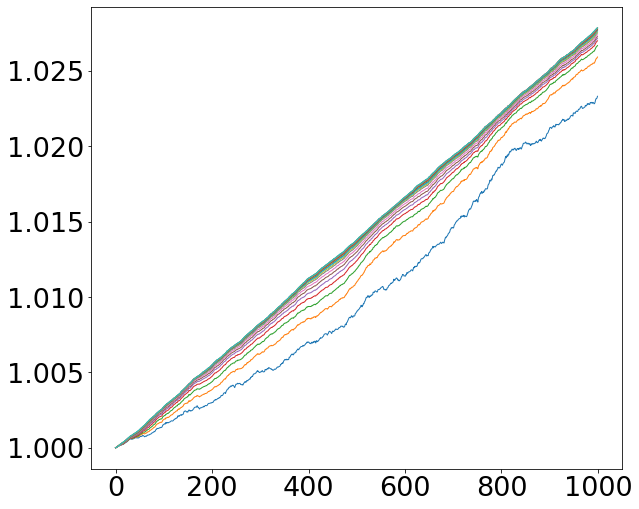

In [101]:
for var in my_variables:
    plt.plot(ey_mean[var]/ey_mean[var][0])

In [102]:
my_rates = [] # type: list
my_residuals = []
my_error = []

for var in my_variables:
    # linear fit
    [m_pn, b_pn], cov_pn = np.polyfit(tspan, ey_mean[var], 1, cov=True)
    # compute the error of the gradient of the fit slope
    err_pn = np.sqrt(np.diag(cov_pn))
    # append the results for each ayy value to a list
    my_rates.append(m_pn)
    my_residuals.append(b_pn)
    my_error.append(err_pn)

In [103]:
my_rates[1]

2.3207480774627778e-08

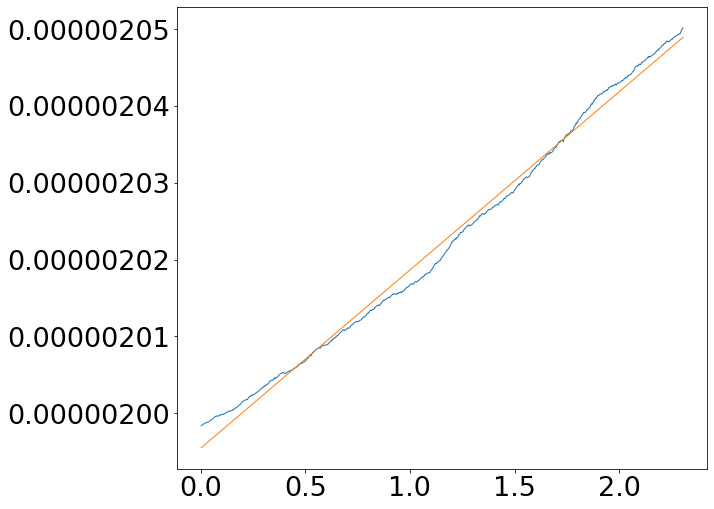

In [61]:
my_index = 1
plt.plot(tspan, ey_mean[my_index], C='C0')
plt.plot(tspan, my_residuals[my_index]+my_rates[my_index]*tspan)

In [24]:
a = np.linspace(-1e-17, -1e-11, 20)

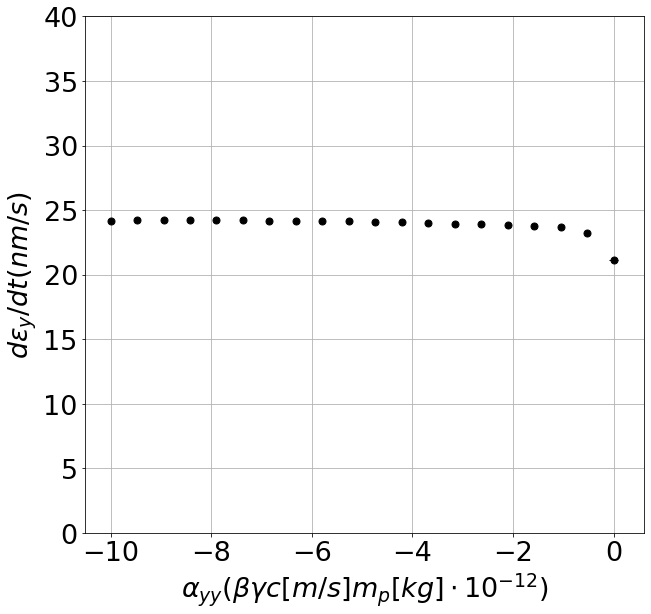

In [32]:
for var in my_variables:
    plt.errorbar(a[var]*1e12, np.array(my_rates[var])*1e9, xerr=np.array(my_error[var][0])*1e9, fmt='.', c='k', ms=14)
#plt.plot(ayy_scan*1e12, np.array(my_rates)*1e9, linewidth=2, c='k')
plt.grid()
plt.xlabel(r'$\alpha_{yy} (\beta \gamma c [m/s] m_p [kg] \cdot 10^{-12}) $')
plt.ylabel(r'$d\epsilon_y / dt (nm/s) $')
plt.tight_layout()
plt.ylim(0, 40)
savefig = False
if savefig:
    plt.savefig('./figures/emittance_grwoth_vs_ayy_pyheadtailunits_{}_set{}.png'.format(type_of_noise, n_set))


In [33]:
filename = f'deyRates_{study_name}Scan_old_studies.pkl'
df = pickle.load(open(filename, 'rb'))

In [35]:
my_df_keys = list(df.keys()) # same keys for both data Frames
print(my_df_keys)

['ayy_0', 'ayy_1', 'ayy_2', 'ayy_3', 'ayy_4', 'ayy_5', 'ayy_6', 'ayy_7', 'ayy_8', 'ayy_9', 'ayy_10', 'ayy_11', 'ayy_12', 'ayy_13', 'ayy_14', 'ayy_15', 'ayy_16', 'ayy_17', 'ayy_18', 'ayy_19']


In [36]:
a = np.linspace(-1e-17, -1e-11, 20)

### Compute the theoretically expected rate

In [37]:
# Machine parameters
betay = 73.81671646 # 73 m at CC2, 76 m at CC1
Vcc = 1e6 # V
Eb = 270e9 # eV
gamma_0 = 287.8 
beta_0 = np.sqrt(1 - 1/gamma_0**2)
circumference = 6911.5623 # m
frev = 299792458/circumference # Hz
sigma_z = 0.155 # m
f_CC = 400.789e6 # CC frequency in Hz
clight = 299792458 # m/s
# Noise kick parameters
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
#PSD_phi = 1.42e-10
#PSD_phi = 1.4e-10
PSD_A = (A_amplitude * scale_factor)**2/frev # V^2/Hz
print(f'psd phi: {PSD_phi} rad^2/Hz, psd A: {PSD_A} V^2/Hz')

psd phi: 1.6806723392287607e-10 rad^2/Hz, psd A: 0.0 V^2/Hz


In [38]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

CDeltaPhi = 0.5168486015622045, CDeltaA = 0.24157569921889774
expected growth = 23.813362141833874 nm/s


Text(0.5, 0, 'Vertical detuning coefficient, $\\mathrm{\\alpha_{yy} \\ 1e12}$ \n [pyheadtail units]')

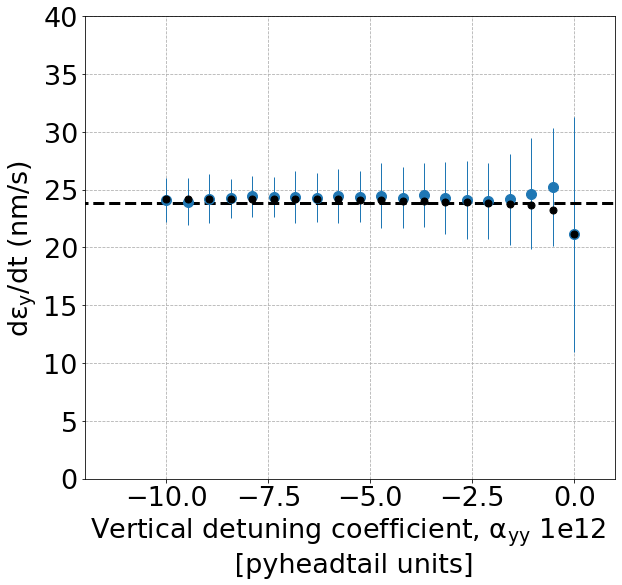

In [54]:
for i, key in enumerate(my_df_keys):
    
    if i ==0:
        my_label_1 = 'wakefields OFF'
        my_label_2 = 'wakefields, ON'
    else:
        my_label_1 = my_label_2 = ''
        
    # errors for study 1
    systematic_error_1 = np.std(df[my_df_keys[i]]['m'])
    statistical_error_1 = np.sqrt(np.mean(np.array(df[my_df_keys[i]]['err'])**2))
    total_error_1 = np.sqrt(systematic_error_1**2+statistical_error_1**2)
    
    
    
    plt.errorbar(a[i]*1e12, np.mean(df[my_df_keys[i]]['m'])*1e9, yerr=total_error_1*1e9, marker='o',  c='C0', label=my_label_1)
    #plt.errorbar(my_variables[i], np.mean(my_df_2[my_df_keys[i]]['m'])*1e9, yerr=total_error_2*1e9, marker='o',  c='C1', label=my_label_2)

#plt.legend(loc=4)

plt.hlines(expected_growth*1e9, -500, 16000, linestyles='dashed', linewidth=3, color='k', label=f'theoretical growth = {expected_growth*1e9:.2f} nm/s')

for var in my_variables:
    plt.errorbar(a[var]*1e12, np.array(my_rates[var])*1e9, yerr=np.array(my_error[var][0])*1e9, fmt='.', c='k', ms=14)

plt.xlim(-12, 1)
plt.ylim(0, 40)
plt.grid(linestyle='dashed')
plt.ylabel(r'$\mathrm{d\epsilon_y / dt \ (nm/s)}$')
plt.xlabel('Vertical detuning coefficient, '+r'$\mathrm{\alpha_{yy} \ 1e12}$'+' \n [pyheadtail units]')

In [62]:
my_rates[1]

2.3207480774627778e-08

In [41]:
#Load the bunch, you need to activate a Pyheadtail version v1.13 or newer
path_to_data = '/afs/cern.ch/work/n/natriant/private/pyheadtail_example_crabcavity/finished_jobs/'
study_name_dq ='sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakefieldsON_500slices_ayy400.0_run0/'
bunch = pickle.load(open(path_to_data+study_name_dq+'bunch', 'rb')) # you need to activate an environment with pyhedtail version at least v1.13.5

PyHEADTAIL v1.13.5




In [42]:
a_standard_units = a/(2*bunch.p0)

Text(0.5, 0, 'Vertical detuning coefficient, $\\mathrm{\\alpha_{yy} \\ 1e4}$ \n [pyheadtail units]')

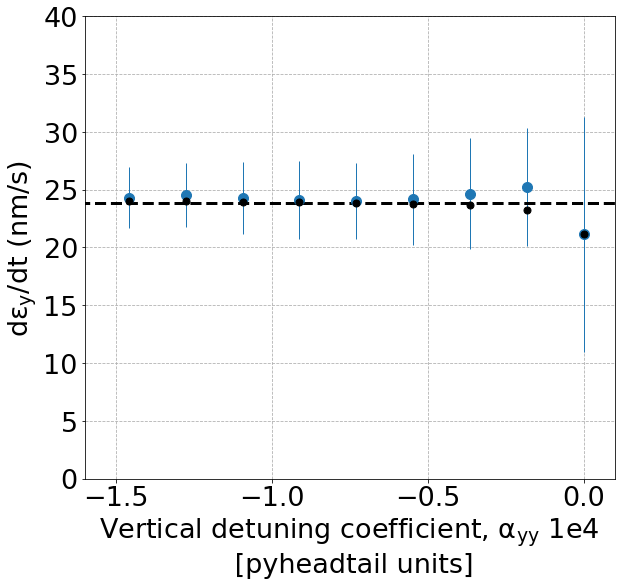

In [58]:
for i, key in enumerate(my_df_keys):
    
    if i ==0:
        my_label_1 = 'wakefields OFF'
        my_label_2 = 'wakefields, ON'
    else:
        my_label_1 = my_label_2 = ''
        
    # errors for study 1
    systematic_error_1 = np.std(df[my_df_keys[i]]['m'])
    statistical_error_1 = np.sqrt(np.mean(np.array(df[my_df_keys[i]]['err'])**2))
    total_error_1 = np.sqrt(systematic_error_1**2+statistical_error_1**2)
    
    
    
    plt.errorbar(a_standard_units[i]*1e-4, np.mean(df[my_df_keys[i]]['m'])*1e9, yerr=total_error_1*1e9, marker='o',  c='C0', label=my_label_1)
    #plt.errorbar(my_variables[i], np.mean(my_df_2[my_df_keys[i]]['m'])*1e9, yerr=total_error_2*1e9, marker='o',  c='C1', label=my_label_2)

#plt.legend(loc=4)

plt.hlines(expected_growth*1e9, -500, 16000, linestyles='dashed', linewidth=3, color='k', label=f'theoretical growth = {expected_growth*1e9:.2f} nm/s')

for var in my_variables:
    plt.errorbar(a_standard_units[var]*1e-4, np.array(my_rates[var])*1e9, yerr=np.array(my_error[var][0])*1e9, fmt='.', c='k', ms=14)

plt.xlim(-1.6, 0.1)
plt.ylim(0, 40)
plt.grid(linestyle='dashed')
plt.ylabel(r'$\mathrm{d\epsilon_y / dt \ (nm/s)}$')
plt.xlabel('Vertical detuning coefficient, '+r'$\mathrm{\alpha_{yy} \ 1e4}$'+' \n [pyheadtail units]')

In [63]:
my_rates[1]

2.3207480774627778e-08

In [64]:
np.mean(df[my_df_keys[1]]['m'])

2.526643327669413e-08